### Netflix Prize Dataset EDA

In this notebook, we will primarily be performing some exploratory data analysis on the Netflix Prize dataset.

Our initial questions that we want to explore with this data set:
1. What are the most rated movies
2. What are the most POORLY rated movies? What are the most Well rated movies?
3. Who are these “top 10k” users?

#### Key Imports

In [338]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go
import glob

In [339]:
DATA_PATH = "../data"
NETFLIX_FOLDER_PATH = os.path.join(DATA_PATH, "netflix_prize")
MAPPING_PATH = os.path.join(DATA_PATH, "netflix_to_imdb.json")

## What are the most rated movies?
- We must first plot the distribution in order to see this 

In [340]:
def load_valid_movies(mapping_path):
    """Load the netflix to IMDB mapping to get valid movie IDs"""
    with open(mapping_path, 'r') as f:
        netflix_to_imdb = json.load(f)
    return set(netflix_to_imdb.keys())  # Convert to set for faster lookups

### process_rating_file()
- Process the various netflix files and count the ratingers per user

In [341]:
def process_rating_file(filepath, valid_movie_ids):
    """Process a single rating file and count ratings for movies in our mapping"""
    ratings_count = 0
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line.endswith(':'):  # Skip user ID lines
                try:
                    movie_id, _, _ = line.split(',')
                    # Convert movie_id to string to match mapping format
                    if str(movie_id) in valid_movie_ids:
                        ratings_count += 1
                except ValueError:
                    continue
    
    return ratings_count

In [342]:
def analyze_ratings_distribution(netflix_folder, mapping_path):
    """Analyze rating counts distribution for mapped movies"""
    # Load valid movie IDs (these are the keys in the mapping)
    with open(mapping_path, 'r') as f:
        netflix_to_imdb = json.load(f)
    valid_movie_ids = set(netflix_to_imdb.keys())  # These are Netflix movie IDs
    print(f"Found {len(valid_movie_ids)} movies in netflix_to_imdb mapping")
    print(f"Sample movie IDs: {list(valid_movie_ids)[:5]}")  # Debug print
    
    # Process all files
    user_ratings = defaultdict(int)
    
    # Get list of files - using full path for training_set directory
    training_set_path = os.path.join(netflix_folder, 'training_set')
    files = glob.glob(os.path.join(training_set_path, 'mv_*.txt'))
    print(f"\nFound {len(files)} rating files")
    
    # Process each file
    total_ratings = 0
    for filepath in tqdm(files, desc="Processing rating files"):
        # Process the file directly using the full filepath
        ratings_count = process_rating_file(filepath, valid_movie_ids)
        
        if ratings_count > 0:
            # Extract user ID from filename
            filename = os.path.basename(filepath)
            user_id = filename.replace('mv_', '').replace('.txt', '')
            user_ratings[user_id] = ratings_count
            total_ratings += ratings_count
    
    print(f"\nTotal users with ratings: {len(user_ratings)}")
    print(f"Total ratings for mapped movies: {total_ratings}")
    
    return user_ratings

In [343]:
def plot_ratings_distribution(user_ratings):
    """Create visualization of ratings distribution"""
    if not user_ratings:
        raise ValueError("No ratings data found!")
        
    ratings_counts = list(user_ratings.values())
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with KDE
    sns.histplot(ratings_counts, bins=50, kde=True)
    
    # Add vertical line for mean
    mean_ratings = sum(ratings_counts) / len(ratings_counts)
    plt.axvline(mean_ratings, color='r', linestyle='--', 
                label=f'Mean: {mean_ratings:.1f}')
    
    # Add vertical line for median
    median_ratings = sorted(ratings_counts)[len(ratings_counts)//2]
    plt.axvline(median_ratings, color='g', linestyle='--', 
                label=f'Median: {median_ratings:.1f}')
    
    # Customize plot
    plt.title('Distribution of Ratings per User\n(Only for Movies in netflix_to_imdb Mapping)')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Count of Users')
    plt.legend()
    
    # Print statistics
    print(f"\nStatistics:")
    print(f"Total users: {len(ratings_counts):,}")
    print(f"Mean ratings per user: {mean_ratings:.1f}")
    print(f"Median ratings per user: {median_ratings:.1f}")
    print(f"Max ratings by a user: {max(ratings_counts):,}")
    print(f"Total ratings: {sum(ratings_counts):,}")
    
    plt.show()

Found 9445 movies in netflix_to_imdb mapping
Sample movie IDs: ['14541', '12083', '5561', '15734', '13831']

Found 17770 rating files


Processing rating files: 100%|██████████| 17770/17770 [00:30<00:00, 577.80it/s]



Total users with ratings: 13733
Total ratings for mapped movies: 357412

Statistics:
Total users: 13,733
Mean ratings per user: 26.0
Median ratings per user: 4.0
Max ratings by a user: 837
Total ratings: 357,412


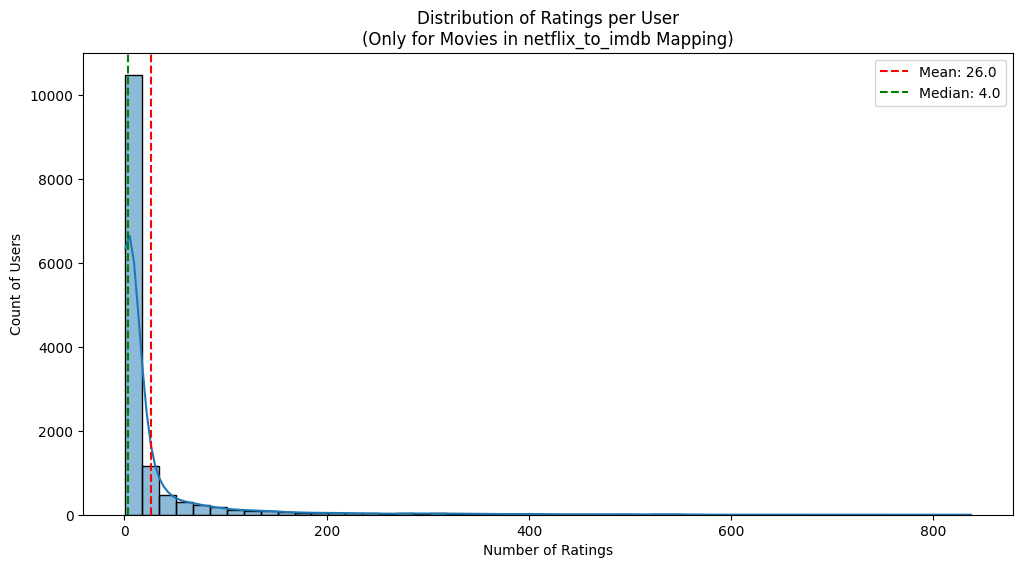

In [344]:
user_ratings = analyze_ratings_distribution(NETFLIX_FOLDER_PATH, MAPPING_PATH)

# Plot distribution
if user_ratings:
    plot_ratings_distribution(user_ratings)
else:
    print("No ratings found! Please check the paths and file format.")

### What are the most POORLY rated movies? What are the most WELL rated movies?
- Where we are only analyzing the top 10k users

In [345]:
TOP_USER_PATH = os.path.join(DATA_PATH, "top_netflix_users.json")

Processing ratings files...
Found 17770 rating files

Processing first file to verify data handling:
Ratings found in first file: 0


100%|██████████| 17770/17770 [00:24<00:00, 721.31it/s]


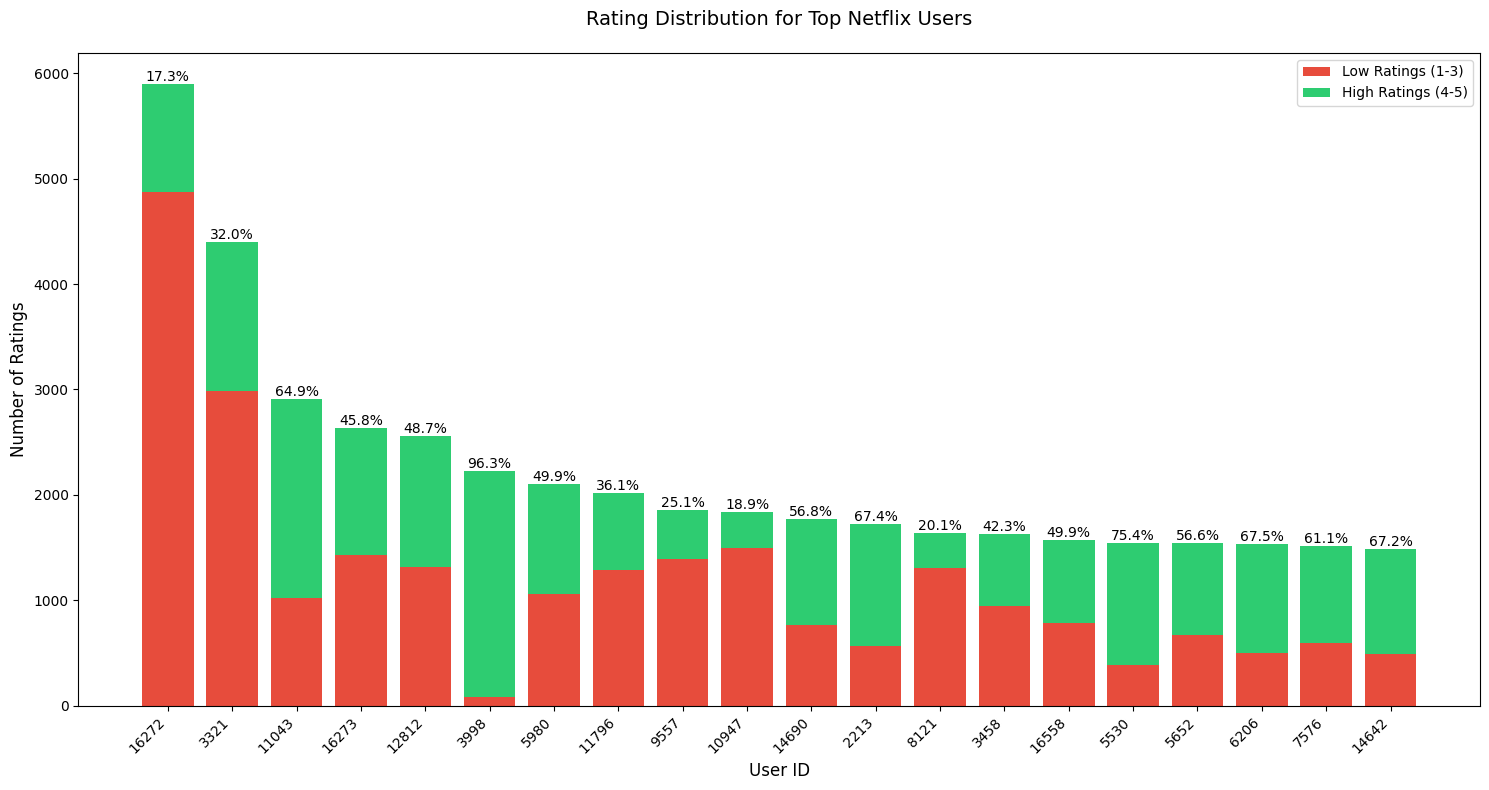


Summary Statistics for Users with Ratings:
Average high ratings ratio: 59.64%
Median high ratings ratio: 60.00%
Range of high ratings ratio: 0.00% to 100.00%

Top 20 Users Detailed Statistics:
       high_ratings  low_ratings  total_ratings high_ratio
16272          1023         4877           5900      17.0%
3321           1407         2988           4395      32.0%
11043          1890         1021           2911      65.0%
16273          1205         1425           2630      46.0%
12812          1245         1313           2558      49.0%
3998           2142           83           2225      96.0%
5980           1051         1056           2107      50.0%
11796           729         1288           2017      36.0%
9557            465         1388           1853      25.0%
10947           347         1493           1840      19.0%
14690          1006          766           1772      57.0%
2213           1162          563           1725      67.0%
8121            329         1309       

In [346]:
# Load the top users data
with open(TOP_USER_PATH, 'r') as f:
    top_users_dict = json.load(f)

# Initialize ratings dictionary
user_ratings = {user_id: {'high_ratings': 0, 'low_ratings': 0} 
                for user_id in top_users_dict.keys()}

def process_ratings_file(filepath):
    """Process a single ratings file and update user_ratings"""
    with open(filepath, 'r') as f:
        # First line contains movie ID
        movie_id = f.readline().strip(':\n')
        
        # Process each rating
        for line in f:
            user_id, rating, _ = line.strip().split(',')
            if user_id in top_users_dict:  # No need to convert to string anymore
                rating = int(rating)
                if rating >= 4:
                    user_ratings[user_id]['high_ratings'] += 1
                else:
                    user_ratings[user_id]['low_ratings'] += 1

# Process all rating files
print("Processing ratings files...")
rating_files = glob.glob(os.path.join(NETFLIX_FOLDER_PATH, 'training_set', 'mv_*.txt'))
print(f"Found {len(rating_files)} rating files")

# Process first file to verify
if rating_files:
    print("\nProcessing first file to verify data handling:")
    process_ratings_file(rating_files[0])
    ratings_found = sum(
        ratings['high_ratings'] + ratings['low_ratings'] 
        for ratings in user_ratings.values()
    )
    print(f"Ratings found in first file: {ratings_found}")

# Process all files
for filepath in tqdm(rating_files):
    process_ratings_file(filepath)

# Convert to DataFrame for visualization
ratings_df = pd.DataFrame.from_dict(user_ratings, orient='index')
ratings_df['total_ratings'] = ratings_df['high_ratings'] + ratings_df['low_ratings']

# Only calculate ratios for users with ratings > 0 to avoid division by zero
ratings_df['high_ratio'] = np.where(
    ratings_df['total_ratings'] > 0,
    ratings_df['high_ratings'] / ratings_df['total_ratings'],
    0
)

# Sort users by total ratings
ratings_df = ratings_df.sort_values('total_ratings', ascending=False)

# Create visualization
plt.figure(figsize=(15, 8))

# Get top 20 users
top_k = 20
top_k_ratings = ratings_df.head(top_k)

# Create stacked bar chart
bottom_bars = plt.bar(range(top_k), top_k_ratings['low_ratings'], 
                     color='#e74c3c', label='Low Ratings (1-3)')
top_bars = plt.bar(range(top_k), top_k_ratings['high_ratings'], 
                  bottom=top_k_ratings['low_ratings'],
                  color='#2ecc71', label='High Ratings (4-5)')

# Customize the plot
plt.title('Rating Distribution for Top Netflix Users', fontsize=14, pad=20)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.legend()

# Rotate x-axis labels
plt.xticks(range(top_k), top_k_ratings.index, rotation=45, ha='right')

# Add percentage labels for non-zero totals
for i in range(top_k):
    total = top_k_ratings.iloc[i]['total_ratings']
    if total > 0:
        high_pct = (top_k_ratings.iloc[i]['high_ratings'] / total * 100)
        plt.text(i, total, f'{high_pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics only for users with ratings
print("\nSummary Statistics for Users with Ratings:")
users_with_ratings = ratings_df[ratings_df['total_ratings'] > 0]
if len(users_with_ratings) > 0:
    print(f"Average high ratings ratio: {users_with_ratings['high_ratio'].mean():.2%}")
    print(f"Median high ratings ratio: {users_with_ratings['high_ratio'].median():.2%}")
    print(f"Range of high ratings ratio: {users_with_ratings['high_ratio'].min():.2%} to {users_with_ratings['high_ratio'].max():.2%}")
else:
    print("No users with ratings found")

# Show detailed statistics for top 20 users
print("\nTop 20 Users Detailed Statistics:")
top_20_stats = ratings_df.head(20).round(2)
top_20_stats['high_ratio'] = np.where(
    top_20_stats['total_ratings'] > 0,
    (top_20_stats['high_ratio'] * 100).round(1).astype(str) + '%',
    'N/A'
)
print(top_20_stats)